In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from ipywidgets import interact


import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.ops import nms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 시작 파라미터 설정

In [3]:
data_dir = '/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/'
train_data_dir = os.path.join(data_dir, 'train/')
val_data_dir = os.path.join(data_dir, 'val/')

csv_data = pd.read_csv(data_dir + 'df.csv')
csv_data = csv_data.drop(columns=['Source', 'Confidence','IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside','XClick1X','XClick2X','XClick3X','XClick4X','XClick1Y','XClick2Y','XClick3Y','XClick4Y'])
csv_data = csv_data[['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax']]
train_data_list = os.listdir(train_data_dir)
val_data_list = os.listdir(val_data_dir)

Class_Name_To_Int = {'Bus':0, 'Truck':1}
Int_To_Class_Name = {0:'Bus', 1:'Truck'}
NUM_CLASSES = 2
VERBOSE_FREQ = 200

# 커스텀데이터셋 설정

In [4]:
class car_data_set():
    def __init__(self, data_dir, phase, csv_data, transformer = None):
        self.csv_data = csv_data
        self.phase_data_dir = (data_dir + phase + '/')
        self.data_list = os.listdir(self.phase_data_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.data_list)
    
    def get_label_def(self, image_name, img_H, img_W):
        label = self.csv_data.loc[(self.csv_data['ImageID'] == image_name.split(".")[0])]
        target_name = [Class_Name_To_Int[i] for i in label['LabelName'].values]
        bounding_box = label.drop(columns = ['ImageID', 'LabelName']).values
        bounding_box[:, [0,2]] *= img_W
        bounding_box[:, [1,3]] *= img_H

        return target_name, bounding_box
    

    def __getitem__(self, index):
        image_name = self.data_list[index]
        
        
        image = cv2.imread(self.phase_data_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        img_H, img_W,_ = image.shape

        if self.transformer:
            image = self.transformer(image)
            _, img_H, img_W = image.shape


        target_name, bounding_box = self.get_label_def(image_name,img_H, img_W)

        target = {}
        target['boxes'] = torch.Tensor(bounding_box).float()
        target['labels'] = torch.Tensor(target_name).long()
        
        
        return image, target

In [5]:
def collate_fn(batch):
    image_list = []
    target_list = []

    for a,b in batch:
        image_list.append(a)
        target_list.append(b)
    
    return image_list, target_list

In [6]:
def build_dataloader(data_dir,csv_data, train_batch_size, val_batch_size):
    
    dataloaders = {}
    train_data_set = car_data_set(data_dir=data_dir, phase='train', csv_data=csv_data, transformer=transformer)
    val_data_set = car_data_set(data_dir=data_dir, phase='val', csv_data=csv_data, transformer=transformer)

    dataloaders['train'] = DataLoader(train_data_set,batch_size = train_batch_size, num_workers=12, pin_memory=True, shuffle=True, collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(val_data_set, batch_size = val_batch_size, num_workers=12, pin_memory=True, shuffle=False, collate_fn=collate_fn)
    return dataloaders

# 이미지 데이터 확인 (transformer사용 X)

In [7]:
temp_set = car_data_set(data_dir=data_dir, phase='train', csv_data=csv_data, transformer=None)

#@interact(index=(0,len(train_data_set)-1))
def show_sample(index=0):
    images, target = temp_set[index]
    boundingbox = target['boxes']
    targetname = target['labels']

    fig, ax = plt.subplots()
    ax.imshow(images)

    for bbox,target in zip(boundingbox, targetname):
        target = Int_To_Class_Name[target.item()]
        xmin = bbox[0] 
        ymin = bbox[1]
        ax.text(xmin, ymin, target,color='red' )
        ax.add_patch(patches.Rectangle(
            (xmin, ymin), bbox[2]-bbox[0], bbox[3]-bbox[1],
            fill=False,
            edgecolor = 'red',
            linewidth=1))
    plt.show()


# 이미지 데이터 확인 (transformer사용 O)

In [8]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(448, 448), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

temp_set = car_data_set(data_dir=data_dir, phase='train', csv_data=csv_data, transformer=transformer)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def unnormalize(image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    image = image * std + mean
    return image

#@interact(index=(0,len(train_data_set)-1))
def show_sample(index=0):
    images, target = temp_set[index]
    boundingbox = target['boxes']
    targetname = target['labels']

    fig, ax = plt.subplots()

    images = unnormalize(image=images, mean=mean, std=std)
    images = images.permute(1,2,0).numpy()
    ax.imshow(images)

    for bbox,target in zip(boundingbox, targetname):
        target = Int_To_Class_Name[target.item()]
        xmin = bbox[0] 
        ymin = bbox[1]
        ax.text(xmin, ymin, target,color='red' )
        ax.add_patch(patches.Rectangle(
            (xmin, ymin), bbox[2]-bbox[0], bbox[3]-bbox[1],
            fill=False,
            edgecolor = 'red',
            linewidth=1))
    plt.show()


# 모델 생성

In [9]:
def build_model():
    model = models.detection.fasterrcnn_resnet50_fpn(pretrain=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
    return model

# one_epoch설정

In [9]:
def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)

    model.train()

    for phase in ['train', 'val']:
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0]
            targets = batch[1] 

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.set_grad_enabled(phase == 'train'):
                loss = model(images, targets)
            total_loss = sum(each_loss for each_loss in loss.values())

            if phase == 'train':
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                if(index>0) and (index % 100) == 0:
                    text = f"{index}/{len(dataloaders[phase])} - "
                    for k,v in loss.items():
                        text += f"{k} : {v.item():.4f} "
                    print(text)
                
                for k, v in loss.items():
                    train_loss[k] += v.item()
                train_loss['total_loss'] += total_loss.item()
            
            else:
                for k, v in loss.items():
                    val_loss[k] += v.item()
                val_loss['total_loss'] +=total_loss.item()
    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])
    return train_loss, val_loss

# 학습 파라미터와 학습

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
dataloaders = build_dataloader(data_dir=data_dir, csv_data=csv_data, train_batch_size=35, val_batch_size=10)
model = build_model().to(device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
num_epoch=30

train_losses = []
val_losses = []

for epoch in range(num_epoch):
    train_loss, val_loss = train_one_epoch(dataloaders=dataloaders, model=model, optimizer=optimizer, device=device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"epoch: {epoch+1}/{num_epoch} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
    
    if (epoch+1) % 10 == 0:
        os.makedirs('./trained_model/', exist_ok=True)
        torch.save(model, os.path.join('./trained_model/','bestmodel.pt'),_use_new_zipfile_serialization=False)


100/392 - loss_classifier : 0.0477 loss_box_reg : 0.0478 loss_objectness : 0.0583 loss_rpn_box_reg : 0.0139 
200/392 - loss_classifier : 0.0432 loss_box_reg : 0.0320 loss_objectness : 0.0646 loss_rpn_box_reg : 0.0182 
300/392 - loss_classifier : 0.0663 loss_box_reg : 0.0648 loss_objectness : 0.0616 loss_rpn_box_reg : 0.0181 
epoch: 1/30 - Train Loss: 0.2117, Val Loss: 0.1889
100/392 - loss_classifier : 0.0506 loss_box_reg : 0.0506 loss_objectness : 0.0654 loss_rpn_box_reg : 0.0227 
200/392 - loss_classifier : 0.0570 loss_box_reg : 0.0574 loss_objectness : 0.0334 loss_rpn_box_reg : 0.0099 
300/392 - loss_classifier : 0.0757 loss_box_reg : 0.0722 loss_objectness : 0.0619 loss_rpn_box_reg : 0.0193 
epoch: 2/30 - Train Loss: 0.1831, Val Loss: 0.1849
100/392 - loss_classifier : 0.0500 loss_box_reg : 0.0504 loss_objectness : 0.0319 loss_rpn_box_reg : 0.0090 
200/392 - loss_classifier : 0.0634 loss_box_reg : 0.0685 loss_objectness : 0.0418 loss_rpn_box_reg : 0.0146 
300/392 - loss_classifier 

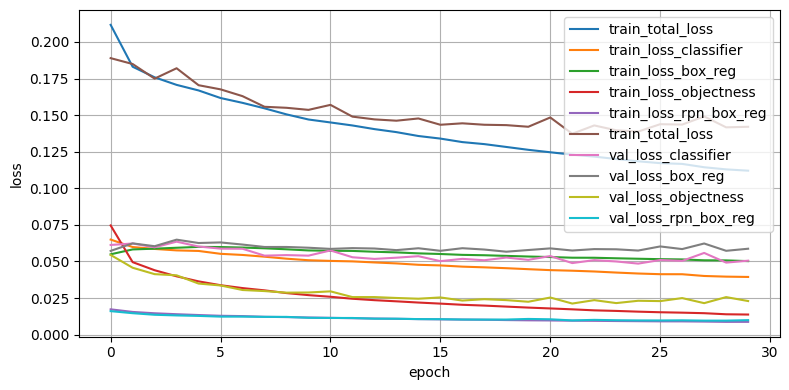

In [13]:
tr_loss_classifier = [] 
tr_loss_box_reg = []
tr_loss_objectness = []
tr_loss_rpn_box_reg = []
tr_loss_total = []

for tr_loss in train_losses:
    tr_loss_classifier.append(tr_loss['loss_classifier'])
    tr_loss_box_reg.append(tr_loss['loss_box_reg'])
    tr_loss_objectness.append(tr_loss['loss_objectness'])
    tr_loss_rpn_box_reg.append(tr_loss['loss_rpn_box_reg'])
    tr_loss_total.append(tr_loss['total_loss'])

val_loss_classifier = [] 
val_loss_box_reg = []
val_loss_objectness = []
val_loss_rpn_box_reg = []
val_loss_total = []

for vl_loss in val_losses:
    val_loss_classifier.append(vl_loss['loss_classifier'])
    val_loss_box_reg.append(vl_loss['loss_box_reg'])
    val_loss_objectness.append(vl_loss['loss_objectness'])
    val_loss_rpn_box_reg.append(vl_loss['loss_rpn_box_reg'])
    val_loss_total.append(vl_loss['total_loss'])

plt.figure(figsize=(8, 4))
plt.plot(tr_loss_total, label="train_total_loss")
plt.plot(tr_loss_classifier, label="train_loss_classifier")
plt.plot(tr_loss_box_reg,  label="train_loss_box_reg")
plt.plot(tr_loss_objectness, label="train_loss_objectness")
plt.plot(tr_loss_rpn_box_reg,  label="train_loss_rpn_box_reg")

plt.plot(val_loss_total, label="train_total_loss")
plt.plot(val_loss_classifier, label="val_loss_classifier")
plt.plot(val_loss_box_reg,  label="val_loss_box_reg")
plt.plot(val_loss_objectness, label="val_loss_objectness")
plt.plot(val_loss_rpn_box_reg,  label="val_loss_rpn_box_reg")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

# 학습된 모델 불러오기

In [37]:
device = 'cpu'
dataloaders = build_dataloader(data_dir=data_dir, csv_data=csv_data, train_batch_size=1, val_batch_size=1)

test_model = build_model()
test_model = torch.load('./trained_model/bestmodel.pt')
test_model.eval().to(device=device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# 겹치는거 확인해주는 구간

In [38]:

for index, batch in enumerate(dataloaders['val']):
    images = batch[0]
    images = list(image.to(device) for image in images)

    with torch.no_grad():
        prediction = test_model(images)

    if index == 0:
        break

In [39]:
print(prediction)

[{'boxes': tensor([[ 58.9129, 124.2985, 416.4781, 379.4574],
        [ 43.7079, 138.8575, 257.1353, 362.1942]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9625, 0.0703])}]


In [55]:
def postprocess(prediction, conf_thres=0.2 ,IOU_threshold=0.1):
    pred_box = prediction['boxes'].cpu().detach().numpy()
    pred_label = prediction['labels'].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()

    conf_thres = 0.2
    valid_index = pred_conf > conf_thres
    pred_box = pred_box[valid_index]
    pred_label = pred_label[valid_index]
    pred_conf = pred_conf[valid_index]

    valid_index = nms(torch.tensor(pred_box.astype(np.float32)), torch.tensor(pred_conf), IOU_threshold)
    pred_box = pred_box[valid_index.numpy()]
    pred_conf = pred_conf[valid_index.numpy()]
    pred_label = pred_label[valid_index.numpy()]
    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis=1)

In [60]:
def process_image(image_path):
    # Load the pre-trained model
    test_model = torch.load('./trained_model/bestmodel.pt')
    test_model.eval().to('cpu')

    # Define the transformation
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(448, 448), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # Read and transform the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transformed_image = transformer(image)

    # Make predictions
    with torch.no_grad():
        prediction = test_model(transformed_image.unsqueeze(dim=0))
    
    prediction = postprocess(prediction[0])
    
    return image, prediction



In [61]:
val_path = '/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/val/'
val_list = os.listdir('/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/val/')

@interact(index=(0, len(val_list)-1))
def show_result(index=0):
    image_path = val_path + val_list[index]
    temp_image, temp_prediction = process_image(image_path)
    fig, ax = plt.subplots()
    image = cv2.resize(temp_image, (448,448))
    ax.imshow(image)

    Int_To_Class_Name = {0: 'bus', 1: 'Truck'}
    boundingbox = temp_prediction[:, 0:4]
    targetname = temp_prediction[:, 5]

    for bbox, target in zip(boundingbox, targetname):
        xmin = max(0, min(bbox[0], 448))
        ymin = max(0, min(bbox[1], 448))
        xmax = max(0, min(bbox[2], 448))
        ymax = max(0, min(bbox[3], 448))
        target = Int_To_Class_Name[target]
        ax.text(xmin, ymin, target, color='red')
        ax.add_patch(patches.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                    fill=False,
                    edgecolor='red',
                    linewidth=1))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='index', max=1521), Output()), _dom_classes=('widget-inte…